In [ ]:
!pip install Pillow

In [ ]:
!pip install torch
!pip3 install torchvision
import PIL

In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
import numpy as np
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
from collections import OrderedDict
from torch.autograd import Variable
from PIL import Image
from torch.optim import lr_scheduler
import copy
import json
import os
from os.path import exists


In [ ]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


In [13]:
file_id = '1twec7CCOq_muRQbzzLQOUCy8k8NZ2tNf'

# Download dataset
!gdown https://drive.google.com/uc?id={file_id}

# Unzip the downloaded file
!unzip -q PlantVillage.zip

Downloading...
From: https://drive.google.com/uc?id=1twec7CCOq_muRQbzzLQOUCy8k8NZ2tNf
To: /content/PlantVillage.zip
866MB [00:04, 188MB/s]
replace PlantVillage/train/Apple___Apple_scab/01a66316-0e98-4d3b-a56f-d78752cd043f___FREC_Scab 3003.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [14]:
import json

with open('categories.json', 'r') as f:
    cat_to_name = json.load(f)


In [15]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [16]:
nThreads = 4
batch_size = 32
use_gpu = torch.cuda.is_available()


In [17]:
# Define your transforms for the training and validation sets
# Data augmentation and normalization for training
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop(224),
        #transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Load the datasets with ImageFolder

data_dir = 'PlantVillage'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

# Using the image datasets and the trainforms, define the dataloaders
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

class_names = image_datasets['train'].classes


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [18]:
# Build and train your network

# 1. Load resnet-152 pre-trained network
model = models.resnet152(pretrained=True)
# Freeze parameters so we don't backprop through them

for param in model.parameters():
    param.requires_grad = False

#Let's check the model architecture:
    print(model)


Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/hub/checkpoints/resnet152-b121ed2d.pth


Streaming output truncated to the last 5000 lines.
      (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (21): Bottleneck(
      (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Streaming output truncated to the last 5000 lines.
      (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(256, 1024, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
    )
    (21): Bottleneck(
      (conv1): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [19]:
# 2. Define a new, untrained feed-forward network as a classifier, using ReLU activations

# Our input_size matches the in_features of pretrained model


from collections import OrderedDict


# Creating the classifier ordered dictionary first

classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 512)),
                          ('relu', nn.ReLU()),
                          ('fc2', nn.Linear(512, 39)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

# Replacing the pretrained model classifier with our classifier
model.fc = classifier


In [20]:
#Function to train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=20):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best valid accuracy: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model


In [21]:
# Train a model with a pre-trained network
num_epochs = 10
if use_gpu:
    print ("Using GPU: "+ str(use_gpu))
    model = model.cuda()

# NLLLoss because our output is LogSoftmax
criterion = nn.NLLLoss()

# Adam optimizer with a learning rate
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
# Decay LR by a factor of 0.1 every 5 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


model_ft = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=10)


Using GPU: True
Epoch 1/10
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

train Loss: 0.7461 Acc: 0.7824
val Loss: 0.2945 Acc: 0.9041

Epoch 2/10
----------
train Loss: 0.4460 Acc: 0.8599
val Loss: 0.3036 Acc: 0.9016

Epoch 3/10
----------
train Loss: 0.4042 Acc: 0.8724
val Loss: 0.2129 Acc: 0.9300

Epoch 4/10
----------
train Loss: 0.3831 Acc: 0.8777
val Loss: 0.2851 Acc: 0.9134

Epoch 5/10
----------
train Loss: 0.2612 Acc: 0.9171
val Loss: 0.1344 Acc: 0.9548

Epoch 6/10
----------
train Loss: 0.2504 Acc: 0.9187
val Loss: 0.1399 Acc: 0.9516

Epoch 7/10
----------
train Loss: 0.2393 Acc: 0.9220
val Loss: 0.1279 Acc: 0.9547

Epoch 8/10
----------
train Loss: 0.2332 Acc: 0.9258
val Loss: 0.1292 Acc: 0.9558

Epoch 9/10
----------
train Loss: 0.2280 Acc: 0.9263
val Loss: 0.1222 Acc: 0.9591

Epoch 10/10
----------
train Loss: 0.2133 Acc: 0.9313
val Loss: 0.1263 Acc: 0.9588

Training complete in 149m 28s
Best valid accuracy: 0.959106


In [22]:
# Do validation on the test set
def test(model, dataloaders, device):
  model.eval()
  accuracy = 0
  
  model.to(device)
    
  for images, labels in dataloaders['val']:
    images = Variable(images)
    labels = Variable(labels)
    images, labels = images.to(device), labels.to(device)
      
    output = model.forward(images)
    ps = torch.exp(output)
    equality = (labels.data == ps.max(1)[1])
    accuracy += equality.type_as(torch.FloatTensor()).mean()
      
    print("Testing Accuracy: {:.3f}".format(accuracy/len(dataloaders['val'])))


In [23]:
test(model, dataloaders, device)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Testing Accuracy: 0.003
Testing Accuracy: 0.006
Testing Accuracy: 0.008
Testing Accuracy: 0.011
Testing Accuracy: 0.014
Testing Accuracy: 0.017
Testing Accuracy: 0.020
Testing Accuracy: 0.022
Testing Accuracy: 0.025
Testing Accuracy: 0.028
Testing Accuracy: 0.031
Testing Accuracy: 0.034
Testing Accuracy: 0.037
Testing Accuracy: 0.039
Testing Accuracy: 0.042
Testing Accuracy: 0.045
Testing Accuracy: 0.048
Testing Accuracy: 0.051
Testing Accuracy: 0.053
Testing Accuracy: 0.056
Testing Accuracy: 0.059
Testing Accuracy: 0.061
Testing Accuracy: 0.064
Testing Accuracy: 0.067
Testing Accuracy: 0.070
Testing Accuracy: 0.073
Testing Accuracy: 0.075
Testing Accuracy: 0.078
Testing Accuracy: 0.081
Testing Accuracy: 0.084
Testing Accuracy: 0.086
Testing Accuracy: 0.089
Testing Accuracy: 0.092
Testing Accuracy: 0.095
Testing Accuracy: 0.098
Testing Accuracy: 0.100
Testing Accuracy: 0.103
Testing Accuracy: 0.106
Testing Accuracy: 0.109
Testing Accuracy: 0.111
Testing Accuracy: 0.114
Testing Accuracy

In [24]:
# Save the checkpoint 

model.class_to_idx = dataloaders['train'].dataset.class_to_idx
model.epochs = num_epochs
checkpoint = {'input_size': [3, 224, 224],
                 'batch_size': dataloaders['train'].batch_size,
                  'output_size': 39,
                  'state_dict': model.state_dict(),
                  'data_transforms': data_transforms,
                  'optimizer_dict':optimizer.state_dict(),
                  'class_to_idx': model.class_to_idx,
                  'epoch': model.epochs}
model_save_name = 'plants9615_checkpoint.pth'
path = F"/content/drive/MyDrive/{model_save_name}" 

torch.save(checkpoint, path)


In [25]:
#It is to load model

In [26]:
# Write a function that loads a checkpoint and rebuilds the model

def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = models.resnet152()
    
    # Our input_size matches the in_features of pretrained model
    input_size = 2048
    output_size = 39
    
    classifier = nn.Sequential(OrderedDict([
                          ('fc1', nn.Linear(2048, 512)),
                          ('relu', nn.ReLU()),
                          #('dropout1', nn.Dropout(p=0.2)),
                          ('fc2', nn.Linear(512, 39)),
                          ('output', nn.LogSoftmax(dim=1))
                          ]))

# Replacing the pretrained model classifier with our classifier
    model.fc = classifier
    
    
    model.load_state_dict(checkpoint['state_dict'])
    
    return model, checkpoint['class_to_idx']
model_save_name = 'plants9615_checkpoint.pth'
path = F"/content/drive/MyDrive/{model_save_name}" 
# Get index to class mapping
loaded_model, class_to_idx = load_checkpoint(path)
idx_to_class = { v : k for k,v in class_to_idx.items()}


In [27]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # Process a PIL image for use in a PyTorch model

    size = 256, 256
    image.thumbnail(size, Image.ANTIALIAS)
    image = image.crop((128 - 112, 128 - 112, 128 + 112, 128 + 112))
    npImage = np.array(image)
    npImage = npImage/255.
        
    imgA = npImage[:,:,0]
    imgB = npImage[:,:,1]
    imgC = npImage[:,:,2]
    
    imgA = (imgA - 0.485)/(0.229) 
    imgB = (imgB - 0.456)/(0.224)
    imgC = (imgC - 0.406)/(0.225)
        
    npImage[:,:,0] = imgA
    npImage[:,:,1] = imgB
    npImage[:,:,2] = imgC
    
    npImage = np.transpose(npImage, (2,0,1))
    
    return npImage


In [28]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.numpy().transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax


In [29]:
def predict(image_path, model, topk=5):
    ''' Predict the class (or classes) of an image using a trained deep learning model.
    '''
    
    # Implement the code to predict the class from an image file
    
    image = torch.FloatTensor([process_image(Image.open(image_path))])
    model.eval()
    output = model.forward(Variable(image))
    pobabilities = torch.exp(output).data.numpy()[0]
    

    top_idx = np.argsort(pobabilities)[-topk:][::-1] 
    top_class = [idx_to_class[x] for x in top_idx]
    top_probability = pobabilities[top_idx]

    return top_probability, top_class


In [30]:
a,b = (predict('PlantVillage/val/Blueberry___healthy/06eacfab-fb39-40e0-bbce-927bc98fa2ac___RS_HL 2663.JPG', loaded_model))
print(type(a))
print(type(b))

<class 'numpy.ndarray'>
<class 'list'>


In [31]:
# Display an image along with the top 5 classes
def view_classify(img, probabilities, classes, mapper):
    ''' Function for viewing an image and it's predicted classes.
    '''
    img_filename = img.split('/')[-2]
    img = Image.open(img)

    fig, (ax1, ax2) = plt.subplots(figsize=(6,10), ncols=1, nrows=2)
    flower_name = mapper[img_filename]
    
    ax1.set_title(flower_name)
    ax1.imshow(img)
    ax1.axis('off')
    
    y_pos = np.arange(len(probabilities))
    ax2.barh(y_pos, probabilities)
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels([mapper[x] for x in classes])
    ax2.invert_yaxis()


PlantVillage/val/Apple___Black_rot/0139bc6d-391c-4fd1-bcae-cc74dabfddd7___JR_FrgE.S 2734.JPG


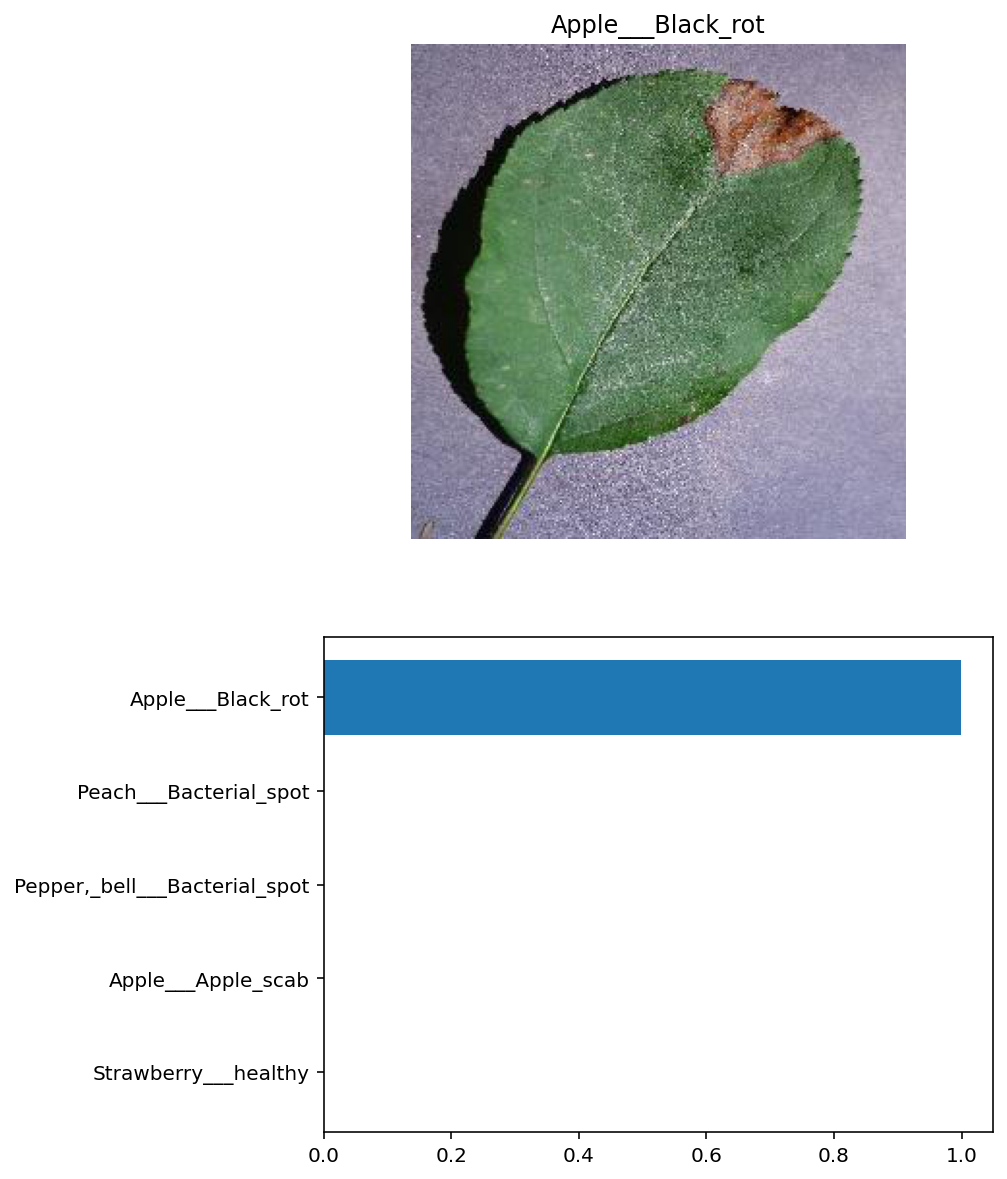

In [32]:
img = 'PlantVillage/val/Apple___Black_rot/0139bc6d-391c-4fd1-bcae-cc74dabfddd7___JR_FrgE.S 2734.JPG'
#img = 'PlantVillage/val/Tomato___Bacterial_spot/00728f4d-83a0-49f1-87f8-374646fcda05___GCREC_Bact.Sp 6326.JPG'
#img = 'PlantVillage/val/Corn_(maize)___Northern_Leaf_Blight/00a14441-7a62-4034-bc40-b196aeab2785___RS_NLB 3932.JPG'
#img = '/content/PlantVillage/val/Blueberry___healthy/02159532-6430-4006-a245-421593949304___RS_HL 2686.JPG'
#img = 'PlantVillage/val/Apple___healthy/3af9dc00-a64b-4b45-a034-1d190e5277ea___RS_HL 7788.JPG'
#img = 'PlantVillage/val/Potato___Late_blight/0acdc2b2-0dde-4073-8542-6fca275ab974___RS_LB 4857.JPG'
#img = 'PlantVillage/val/Tomato___Tomato_Yellow_Leaf_Curl_Virus/0e1fda76-d958-490f-9fcb-21e86c99dbe6___UF.GRC_YLCV_Lab 02200.JPG'
print(img)
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)


PlantVillage/val/Tomato___Bacterial_spot/00728f4d-83a0-49f1-87f8-374646fcda05___GCREC_Bact.Sp 6326.JPG


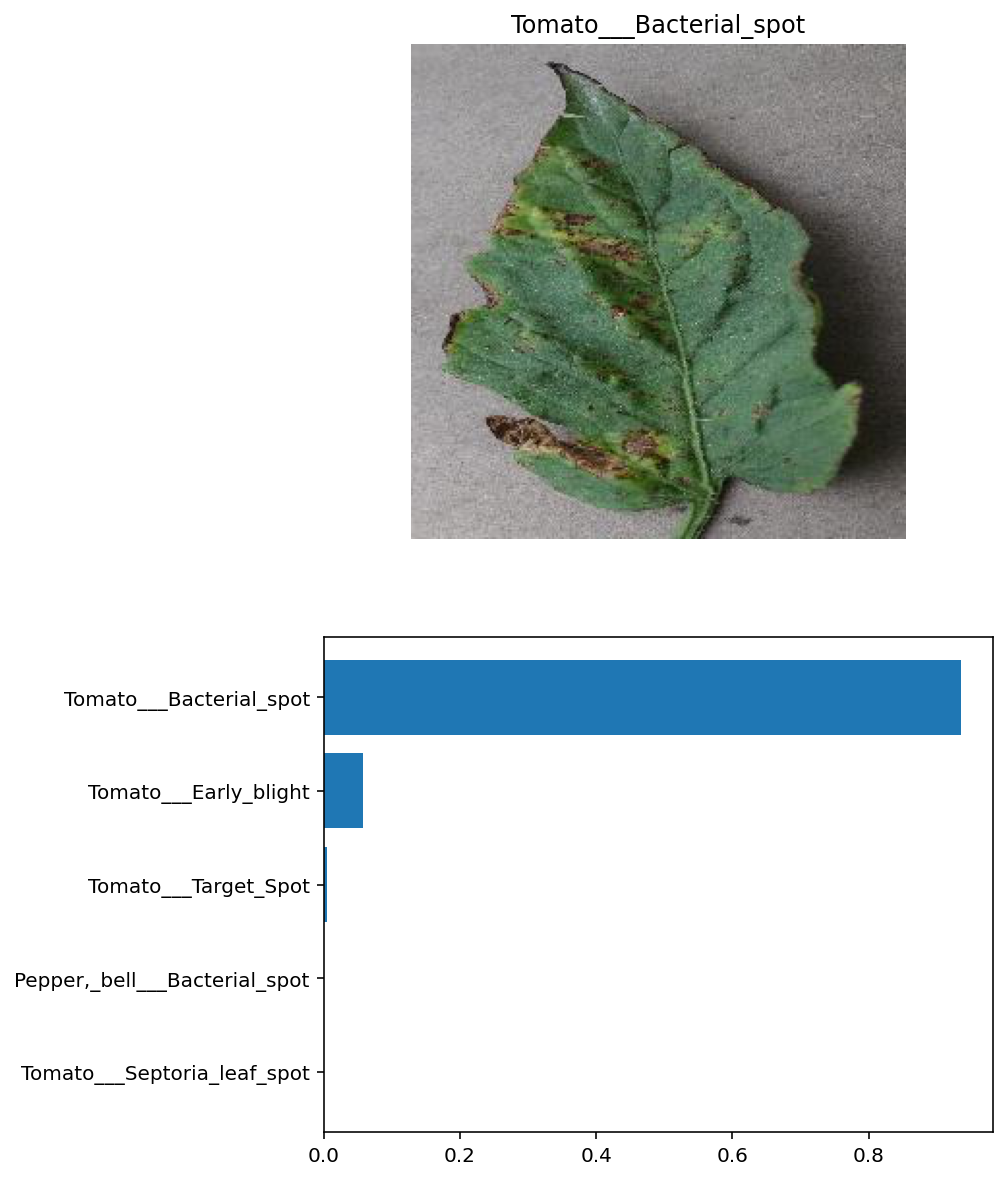

In [33]:
#img = 'PlantVillage/val/Apple___Black_rot/0139bc6d-391c-4fd1-bcae-cc74dabfddd7___JR_FrgE.S 2734.JPG'
img = 'PlantVillage/val/Tomato___Bacterial_spot/00728f4d-83a0-49f1-87f8-374646fcda05___GCREC_Bact.Sp 6326.JPG'
#img = 'PlantVillage/val/Corn_(maize)___Northern_Leaf_Blight/00a14441-7a62-4034-bc40-b196aeab2785___RS_NLB 3932.JPG'
#img = '/content/PlantVillage/val/Blueberry___healthy/02159532-6430-4006-a245-421593949304___RS_HL 2686.JPG'
#img = 'PlantVillage/val/Apple___healthy/3af9dc00-a64b-4b45-a034-1d190e5277ea___RS_HL 7788.JPG'
#img = 'PlantVillage/val/Potato___Late_blight/0acdc2b2-0dde-4073-8542-6fca275ab974___RS_LB 4857.JPG'
#img = 'PlantVillage/val/Tomato___Tomato_Yellow_Leaf_Curl_Virus/0e1fda76-d958-490f-9fcb-21e86c99dbe6___UF.GRC_YLCV_Lab 02200.JPG'
print(img)
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)


PlantVillage/val/Corn_(maize)___Northern_Leaf_Blight/00a14441-7a62-4034-bc40-b196aeab2785___RS_NLB 3932.JPG


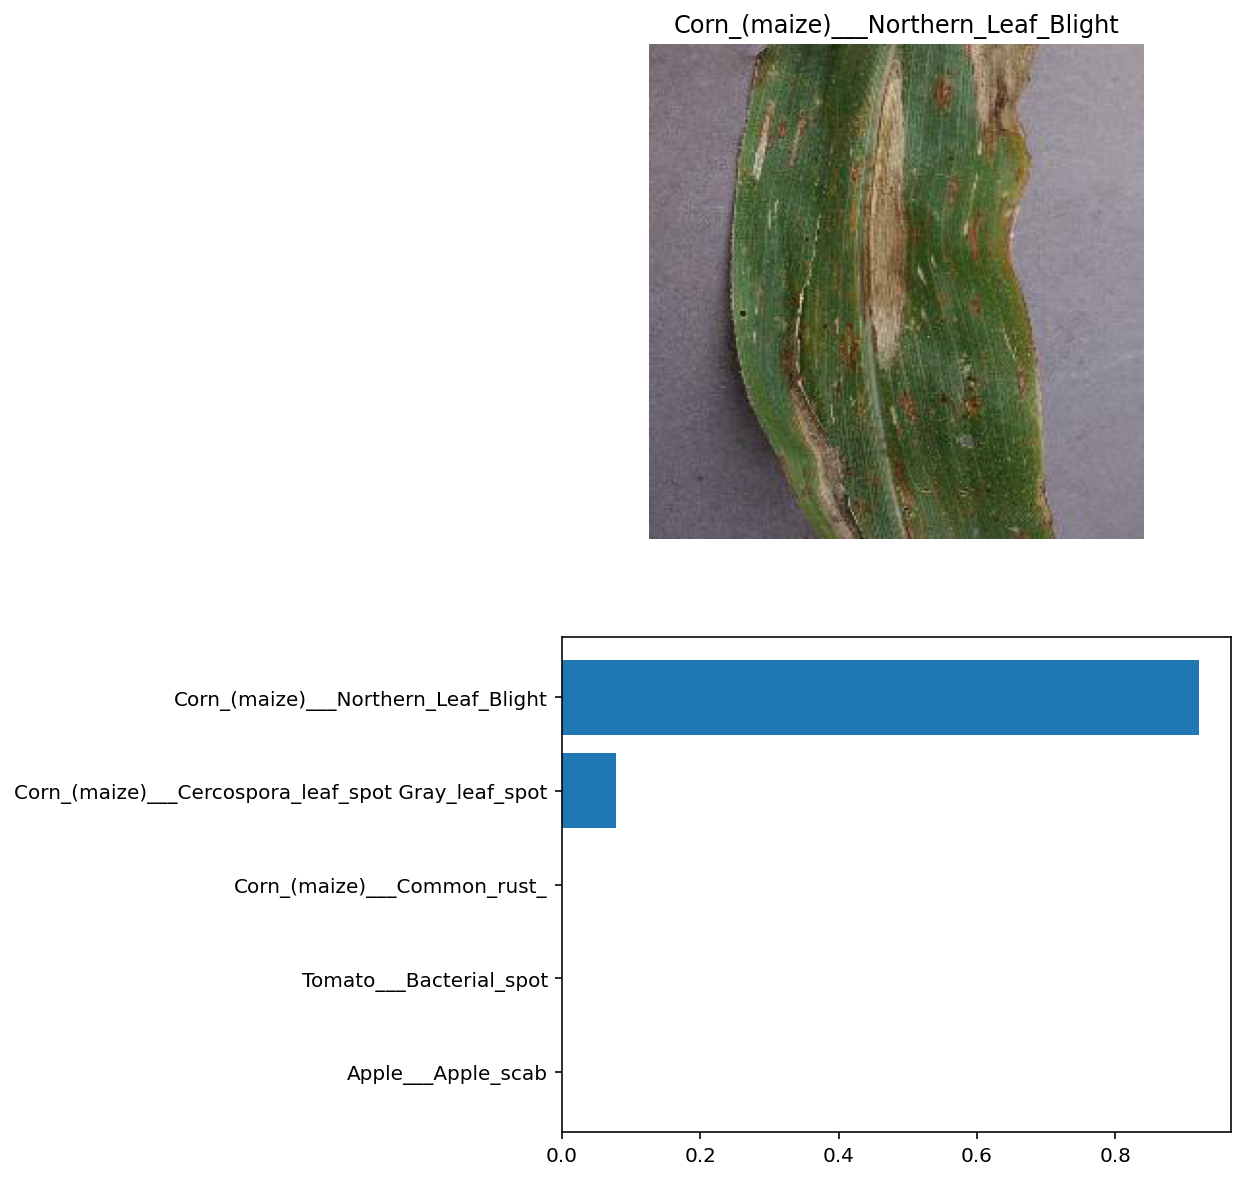

In [34]:
#img = 'PlantVillage/val/Apple___Black_rot/0139bc6d-391c-4fd1-bcae-cc74dabfddd7___JR_FrgE.S 2734.JPG'
#img = 'PlantVillage/val/Tomato___Bacterial_spot/00728f4d-83a0-49f1-87f8-374646fcda05___GCREC_Bact.Sp 6326.JPG'
img = 'PlantVillage/val/Corn_(maize)___Northern_Leaf_Blight/00a14441-7a62-4034-bc40-b196aeab2785___RS_NLB 3932.JPG'
#img = '/content/PlantVillage/val/Blueberry___healthy/02159532-6430-4006-a245-421593949304___RS_HL 2686.JPG'
#img = 'PlantVillage/val/Apple___healthy/3af9dc00-a64b-4b45-a034-1d190e5277ea___RS_HL 7788.JPG'
#img = 'PlantVillage/val/Potato___Late_blight/0acdc2b2-0dde-4073-8542-6fca275ab974___RS_LB 4857.JPG'
#img = 'PlantVillage/val/Tomato___Tomato_Yellow_Leaf_Curl_Virus/0e1fda76-d958-490f-9fcb-21e86c99dbe6___UF.GRC_YLCV_Lab 02200.JPG'
print(img)
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)


/content/PlantVillage/val/Blueberry___healthy/02159532-6430-4006-a245-421593949304___RS_HL 2686.JPG


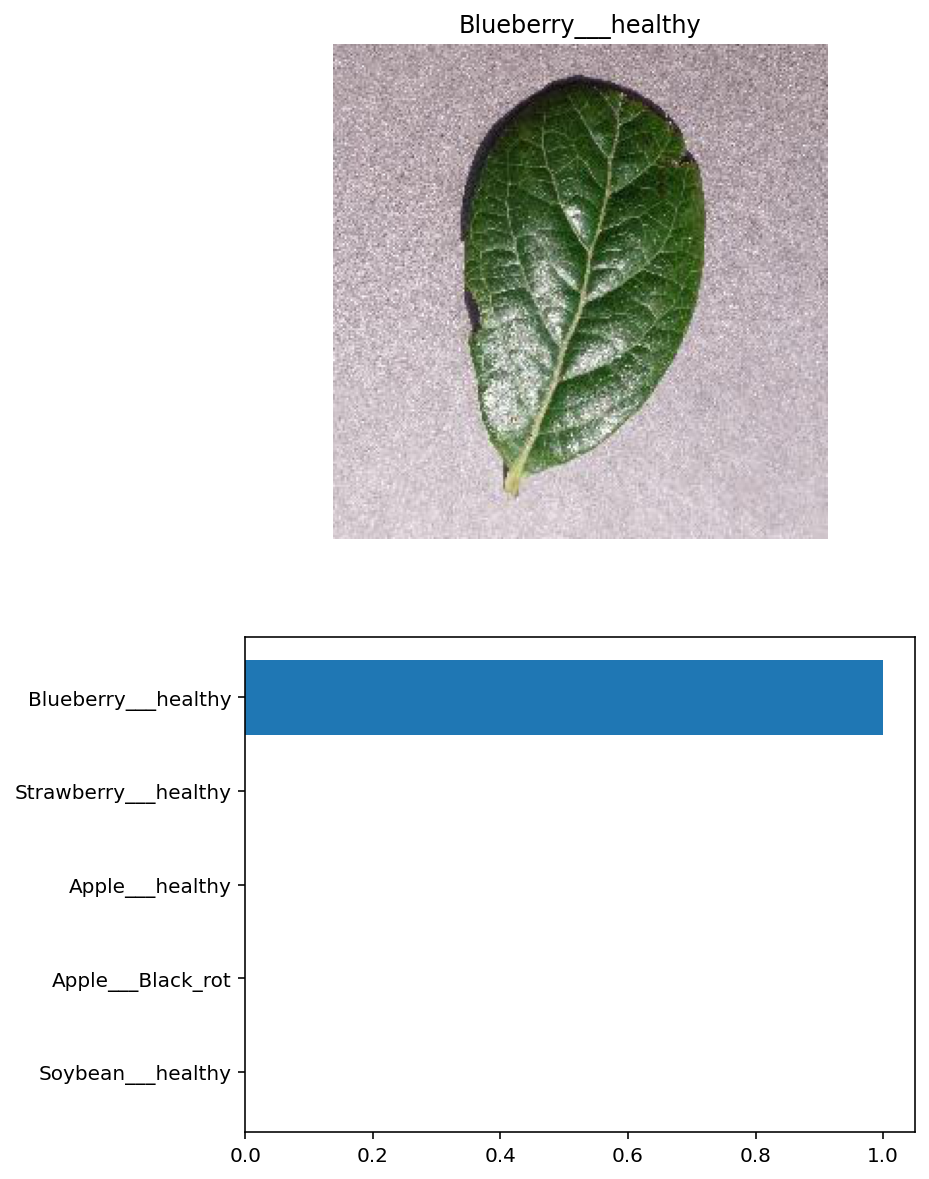

In [35]:
#img = 'PlantVillage/val/Apple___Black_rot/0139bc6d-391c-4fd1-bcae-cc74dabfddd7___JR_FrgE.S 2734.JPG'
#img = 'PlantVillage/val/Tomato___Bacterial_spot/00728f4d-83a0-49f1-87f8-374646fcda05___GCREC_Bact.Sp 6326.JPG'
#img = 'PlantVillage/val/Corn_(maize)___Northern_Leaf_Blight/00a14441-7a62-4034-bc40-b196aeab2785___RS_NLB 3932.JPG'
img = '/content/PlantVillage/val/Blueberry___healthy/02159532-6430-4006-a245-421593949304___RS_HL 2686.JPG'
#img = 'PlantVillage/val/Apple___healthy/3af9dc00-a64b-4b45-a034-1d190e5277ea___RS_HL 7788.JPG'
#img = 'PlantVillage/val/Potato___Late_blight/0acdc2b2-0dde-4073-8542-6fca275ab974___RS_LB 4857.JPG'
#img = 'PlantVillage/val/Tomato___Tomato_Yellow_Leaf_Curl_Virus/0e1fda76-d958-490f-9fcb-21e86c99dbe6___UF.GRC_YLCV_Lab 02200.JPG'
print(img)
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)


PlantVillage/val/Apple___healthy/3af9dc00-a64b-4b45-a034-1d190e5277ea___RS_HL 7788.JPG


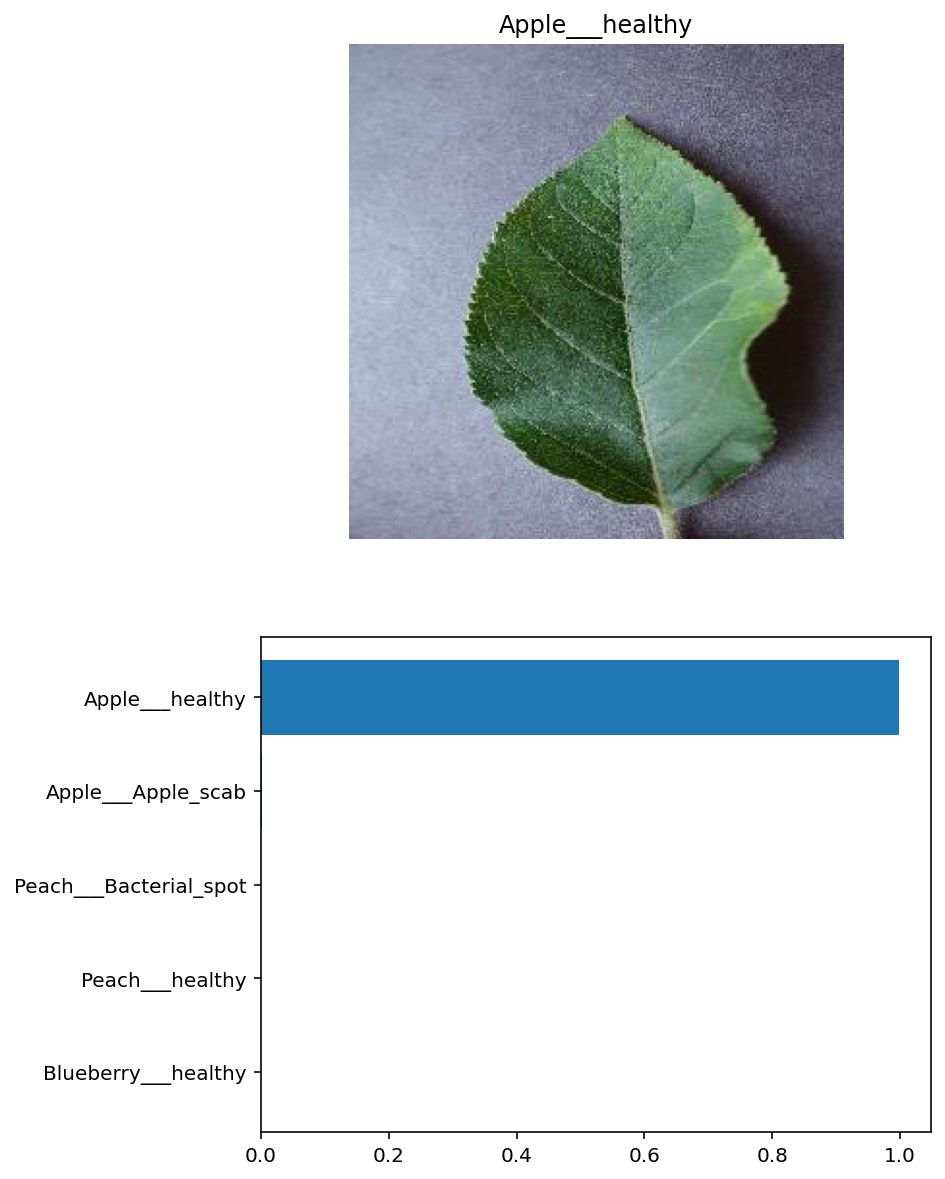

In [36]:
#img = 'PlantVillage/val/Apple___Black_rot/0139bc6d-391c-4fd1-bcae-cc74dabfddd7___JR_FrgE.S 2734.JPG'
#img = 'PlantVillage/val/Tomato___Bacterial_spot/00728f4d-83a0-49f1-87f8-374646fcda05___GCREC_Bact.Sp 6326.JPG'
#img = 'PlantVillage/val/Corn_(maize)___Northern_Leaf_Blight/00a14441-7a62-4034-bc40-b196aeab2785___RS_NLB 3932.JPG'
#img = '/content/PlantVillage/val/Blueberry___healthy/02159532-6430-4006-a245-421593949304___RS_HL 2686.JPG'
img = 'PlantVillage/val/Apple___healthy/3af9dc00-a64b-4b45-a034-1d190e5277ea___RS_HL 7788.JPG'
#img = 'PlantVillage/val/Potato___Late_blight/0acdc2b2-0dde-4073-8542-6fca275ab974___RS_LB 4857.JPG'
#img = 'PlantVillage/val/Tomato___Tomato_Yellow_Leaf_Curl_Virus/0e1fda76-d958-490f-9fcb-21e86c99dbe6___UF.GRC_YLCV_Lab 02200.JPG'
print(img)
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)


PlantVillage/val/Potato___Late_blight/0acdc2b2-0dde-4073-8542-6fca275ab974___RS_LB 4857.JPG


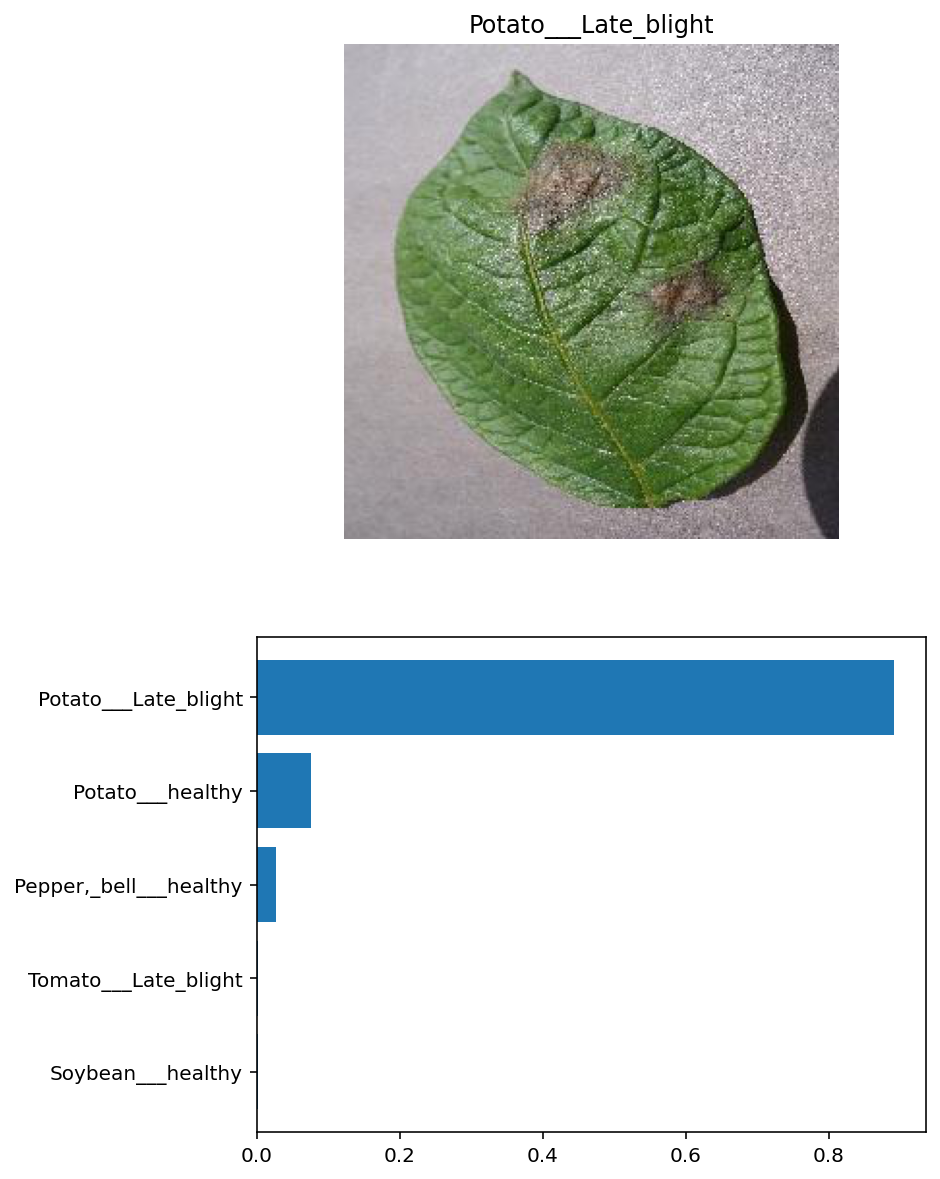

In [37]:
#img = 'PlantVillage/val/Apple___Black_rot/0139bc6d-391c-4fd1-bcae-cc74dabfddd7___JR_FrgE.S 2734.JPG'
#img = 'PlantVillage/val/Tomato___Bacterial_spot/00728f4d-83a0-49f1-87f8-374646fcda05___GCREC_Bact.Sp 6326.JPG'
#img = 'PlantVillage/val/Corn_(maize)___Northern_Leaf_Blight/00a14441-7a62-4034-bc40-b196aeab2785___RS_NLB 3932.JPG'
#img = '/content/PlantVillage/val/Blueberry___healthy/02159532-6430-4006-a245-421593949304___RS_HL 2686.JPG'
#img = 'PlantVillage/val/Apple___healthy/3af9dc00-a64b-4b45-a034-1d190e5277ea___RS_HL 7788.JPG'
img = 'PlantVillage/val/Potato___Late_blight/0acdc2b2-0dde-4073-8542-6fca275ab974___RS_LB 4857.JPG'
#img = 'PlantVillage/val/Tomato___Tomato_Yellow_Leaf_Curl_Virus/0e1fda76-d958-490f-9fcb-21e86c99dbe6___UF.GRC_YLCV_Lab 02200.JPG'
print(img)
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)


PlantVillage/val/Tomato___Tomato_Yellow_Leaf_Curl_Virus/0e1fda76-d958-490f-9fcb-21e86c99dbe6___UF.GRC_YLCV_Lab 02200.JPG


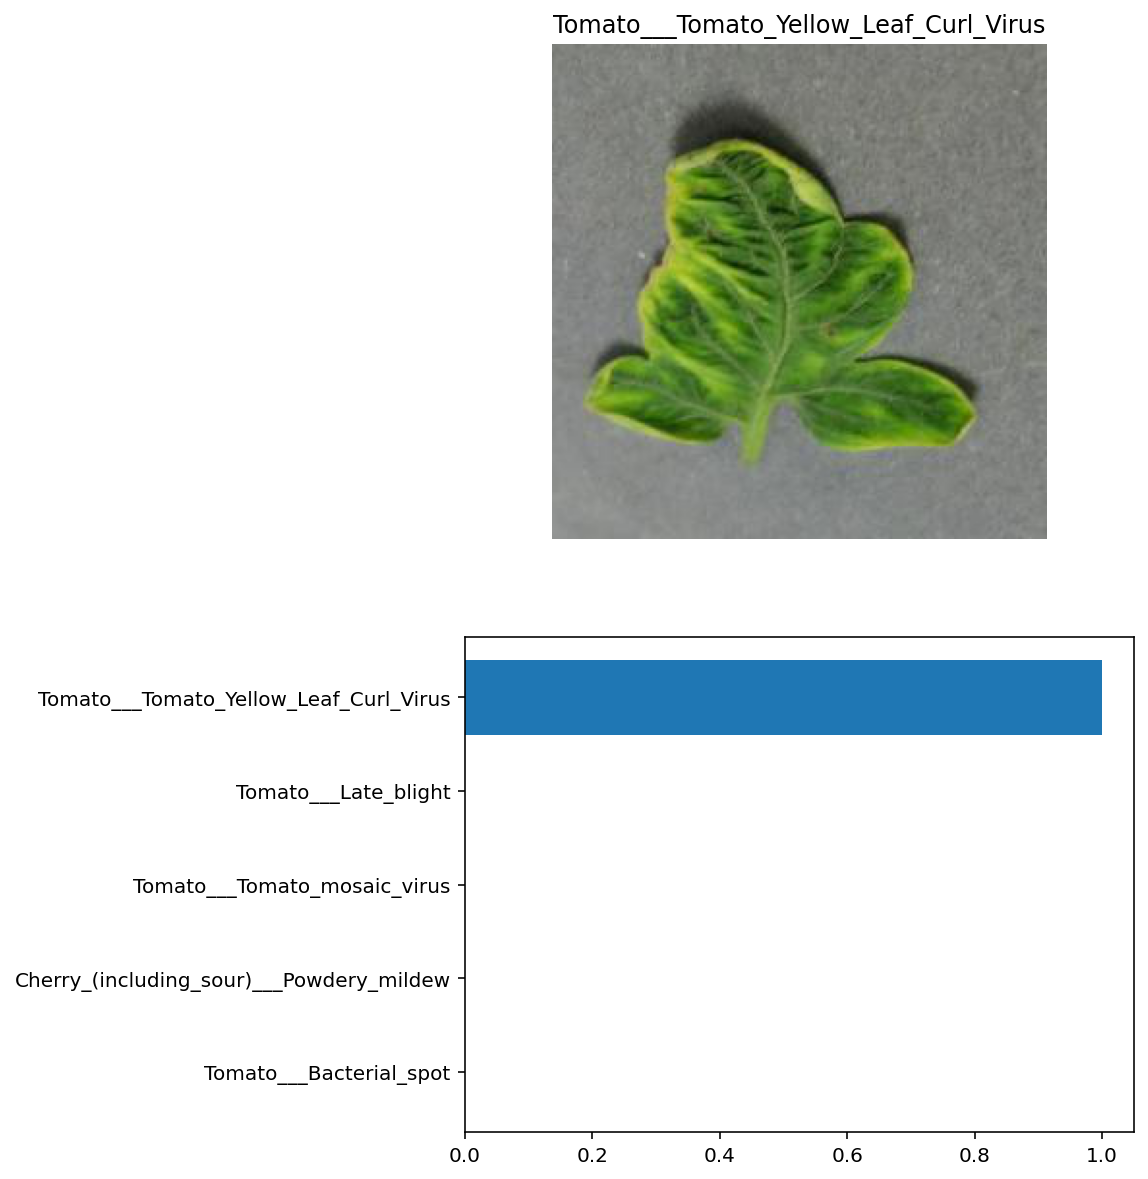

In [38]:
#img = 'PlantVillage/val/Apple___Black_rot/0139bc6d-391c-4fd1-bcae-cc74dabfddd7___JR_FrgE.S 2734.JPG'
#img = 'PlantVillage/val/Tomato___Bacterial_spot/00728f4d-83a0-49f1-87f8-374646fcda05___GCREC_Bact.Sp 6326.JPG'
#img = 'PlantVillage/val/Corn_(maize)___Northern_Leaf_Blight/00a14441-7a62-4034-bc40-b196aeab2785___RS_NLB 3932.JPG'
#img = '/content/PlantVillage/val/Blueberry___healthy/02159532-6430-4006-a245-421593949304___RS_HL 2686.JPG'
#img = 'PlantVillage/val/Apple___healthy/3af9dc00-a64b-4b45-a034-1d190e5277ea___RS_HL 7788.JPG'
#img = 'PlantVillage/val/Potato___Late_blight/0acdc2b2-0dde-4073-8542-6fca275ab974___RS_LB 4857.JPG'
img = 'PlantVillage/val/Tomato___Tomato_Yellow_Leaf_Curl_Virus/0e1fda76-d958-490f-9fcb-21e86c99dbe6___UF.GRC_YLCV_Lab 02200.JPG'
print(img)
p, c = predict(img, loaded_model)
view_classify(img, p, c, cat_to_name)
